In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [32]:
trainPath = "../data/Train.csv"
testPath = "../data/Test.csv"
metaPath = "../data/Meta.csv"

trainCSV = pd.read_csv(trainPath)
testCSV = pd.read_csv(testPath)
metaCSV = pd.read_csv(metaPath)

In [33]:
metaCSV.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [34]:
trainCSV = trainCSV[['Width', 'Height', 'ClassId', 'Path']]
testCSV = testCSV[['Width', 'Height', 'ClassId', 'Path']]
metaCSV = metaCSV[['Path', 'ClassId']]

In [35]:
pathToData = "../data/"
targetPictureSize = (32, 32)

In [36]:
resized_images = []
image_classes = []

# Iterate over the rows of the DataFrame
for index, row in trainCSV.iterrows():
    # Extract the file path and class label from the DataFrame
    file_path = pathToData + row["Path"]  # Replace "file_path_column_name" with your actual column name
    class_label = int(row["ClassId"])  # Replace "class_column_name" with your actual column name
    
    # Check if the file path is valid and the file is a PNG image
    if os.path.isfile(file_path) and file_path.endswith(".png"):
        # Open the image
        image = Image.open(file_path)
        
        # Convert the image to grayscale
        grayscale_image = image.convert("L")
        
        # Resize the grayscale image to 32x32 pixels
        resized_image = grayscale_image.resize(targetPictureSize)
        
        # Transform the resized image into a PyTorch tensor
        transform = torchvision.transforms.ToTensor()
        tensor_image = transform(resized_image)
        converted_tensor = tensor_image.permute(1, 2, 0)
        
        # Add the tensor and its corresponding class label to the lists
        resized_images.append(converted_tensor)
        image_classes.append(class_label)

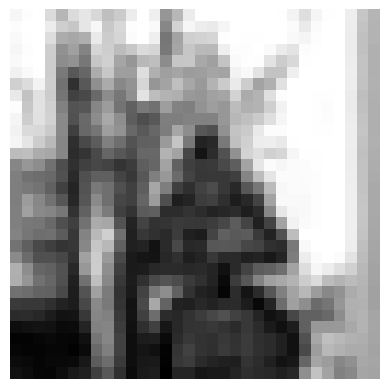

In [37]:
example_image = resized_images[211]

numpy_image = example_image.squeeze().numpy()

# Display the image using matplotlib
plt.imshow(numpy_image, cmap="gray")
plt.axis('off')
plt.show()

In [10]:
try:
    labels_tensor = torch.tensor(image_classes)
    print(labels_tensor.shape)
except:
    print("Error while stacking the images")

torch.Size([39209])


In [48]:
class RegularNN(nn.Module):
    def __init__(self, no_Of_Filters, size_of_Filter, size_of_Filter2, size_of_pool, no_Of_Nodes, noOfClasses):
        super(RegularNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, no_Of_Filters, size_of_Filter)
        self.conv2 = nn.Conv2d(no_Of_Filters, no_Of_Filters, size_of_Filter)
        self.pool = nn.MaxPool2d(size_of_pool)
        self.conv3 = nn.Conv2d(no_Of_Filters, no_Of_Filters // 2, size_of_Filter2)
        self.conv4 = nn.Conv2d(no_Of_Filters // 2, no_Of_Filters // 2, size_of_Filter2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(no_Of_Filters // 2 * 8 * 8, no_Of_Nodes)
        self.fc2 = nn.Linear(no_Of_Nodes, noOfClasses)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.conv4(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define the model parameters
no_Of_Filters = 60
size_of_Filter = 5
size_of_Filter2 = 3
size_of_pool = 2
no_Of_Nodes = 500
noOfClasses = 43

# Create an instance of your model
model = RegularNN(no_Of_Filters, size_of_Filter, size_of_Filter2, size_of_pool, no_Of_Nodes, noOfClasses)
# Print the model summary
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

TypeError: __init__() missing 1 required positional argument: 'kernel_size'

In [46]:
class TrainDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

# Convert your lists of images and labels to tensors
images_tensor = torch.stack(resized_images)
labels_tensor = torch.tensor(image_classes)

# Create an instance of your dataset
dataset = TrainDataset(images_tensor, labels_tensor)

# Set device to GPU if available, otherwise use CPU
device = torch.device("cpu")
model.to(device)

# Create a data loader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [47]:
# Training loop
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        running_loss += loss.item()
    
    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

# Save the trained model
#torch.save(model.state_dict(), "trained_model.pth")

RuntimeError: Given groups=1, weight of size [60, 1, 5, 5], expected input[32, 32, 32, 1] to have 1 channels, but got 32 channels instead